In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 119.1 MB/s eta 0:00:00


In [ ]:
!cp /content/drive/MyDrive/BERT_Capstone/BertModel.py /content
!cp /content/drive/MyDrive/BERT_Capstone/BertTrainer.py /content
!cp /content/drive/MyDrive/BERT_Capstone/CrimeVsNonCrime2.xlsx /content

In [ ]:
import os
import torch
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

from BertModel import BertClassifier
from BertTrainer import Custom_Trainer

In [ ]:
EPOCHS = 3
LR = 1e-5
DECAY = 1e-6
BATCH_SIZE = 16

LABEL_COLUMN = 'label'
get_word_count = False
column_list = ['text', 'label', 'word_count']
labels = {'Crime':0,
          'Non-crime':1}

file_path = "/content/drive/MyDrive/BERT_Capstone/Weights/"

In [ ]:
trainer = Custom_Trainer(EPOCHS, BATCH_SIZE, labels, LABEL_COLUMN, LR, DECAY)

In [ ]:
# train_df = pd.read_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime.xlsx")

df = pd.read_excel("/content/CrimeVsNonCrime2.xlsx")
print(df.describe())
print(f"All entries unique: {df['Title'].nunique()==df.shape[0]}")
print(f"Null cells: {df.isnull().sum().sum()}")

                                                    Title  Label
count                                               68934  68934
unique                                              68393      2
top     Don’t want to play the friend who drives hero ...  Crime
freq                                                    2  35334
All entries unique: False
Null cells: 0


In [ ]:
df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')
print(f"All entries unique: {df['Title'].nunique()==df.shape[0]}")

All entries unique: True


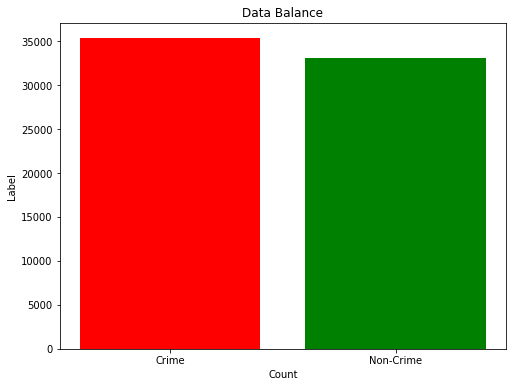

In [ ]:
if not LABEL_COLUMN in column_list:
    raise Exception("Label name in 'filtered_df' do not match with LABEL_COLUMN. Check the label columns and add them to LABEL_COLUMN")

filtered_df = pd.DataFrame(columns=column_list)

filtered_df[LABEL_COLUMN] = (pd.Categorical(df['Label']).codes).astype(int)
label_counts = df['Label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Data Balance')
plt.show()

In [ ]:
# text_list = []
# word_count = []

# for entry in train_df['Title']:
#     new_text = re.sub("[^a-zA-Z ]", " ", entry)
#     new_text = new_text.lower().split()
#     word_count.append(len(new_text))
#     new_text = ' '.join(new_text)
#     text_list.append(new_text)

# filtered_df['text'] = text_list
# filtered_df['word_count'] = word_count

filtered_df['text'] = trainer.preprocess_data_x(df['Title'], get_word_count=get_word_count)

if get_word_count:
  plt.figure(figsize=(8, 6))
  print(f"Average Word count: {np.average(filtered_df['word_count'])}")
  plt.hist(filtered_df['word_count'],color='red')
  plt.title('Word count')
  plt.xlabel('Word_count')
  plt.ylabel('Entry_Count')
  plt.show()

In [ ]:
bert_df = filtered_df.drop(columns=['word_count']) if get_word_count else filtered_df.copy()

df_train, df_val, df_test = np.split(bert_df.sample(frac=1, random_state=42), 
                                     [int(.8*len(bert_df)), int(.9*len(bert_df))])

print(f"Train Size: {len(df_train)}\nValidation Size: {len(df_val)}\nTest Size: {len(df_test)}")

Train Size: 54714
Validation Size: 6839
Test Size: 6840


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model = BertClassifier(bert_model)

In [ ]:
# model_file_name = "/content/drive/MyDrive/BERT_Capstone/Weights/Bert_Epo_3_Acc_906.pt"
# shutil.copy(model_file_name, "/content/Imported_Model_Weights_Temp.pt", )
# model.load_state_dict(torch.load('/content/Imported_Model_Weights_Temp.pt'))

<All keys matched successfully>

In [ ]:
trainer.set_model_tokenizer(model, tokenizer)

In [ ]:
trainer.train(model, df_train, df_val, tokenizer)

TypeError: ignored

In [ ]:
# #torch.save(model, './Bert_Weights/Bert_E2_896')
# torch.save(model.state_dict(), './Bert_Weights/Bert_E2_896.pt')
# new_model = BertClassifier(bert_model)
# new_model.load_state_dict(torch.load('./Bert_Weights/Bert_E2_896.pt'))
# evaluate(new_model, df_test, BATCH_SIZE)

In [ ]:
test_acc, test_loss, outputs, labels = trainer.evaluate(df_test, get_output=True)
print(f'Test Accuracy: {test_acc*100: .3f} | Test Loss: {test_loss: .3f}')

Test Accuracy:  90.614 | Test Loss:  0.021


In [ ]:
y_pred=[]
y_true=[]
for output, label in zip(outputs, labels):
  y_pred.append(output.tolist())
  y_true.append(label.tolist())

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred)
print(cnf_matrix)
sns.heatmap(cnf_matrix/np.sum(cnf_matrix), annot=True, fmt='.2%', xticklabels=labels)

In [ ]:
scores = precision_recall_fscore_support(y_true, y_pred, average='binary')
print(f"Precision: {scores[0]:.3f} | Recall: {scores[1]:.3f} | F-Beta: {scores[2]:.3f}")

Precision: 0.881 | Recall: 0.926 | F-Beta: 0.903


In [ ]:
if not os.path.exists(file_path):
  os.makedirs(file_path)
file_name = file_path + f'Bert_Epo_{EPOCHS}_Acc_{final_acc*1000:.0f}.pt'
torch.save(model.state_dict(), 'Model_Weights_Temp.pt')
shutil.copy("/content/Model_Weights_Temp.pt", file_name)

'/content/drive/MyDrive/BERT_Capstone/Weights/Bert_Epo_3_Acc_906.pt'